Missing values

Take like 50 datasets

Make function to OHE numeric values.

Then run all the analyses below and combine into a DataFrame with all the mean and SDs. Plot the result.

It gets a lot slower with more data. Let's track the time and number of samples and number of columns.

The scikitlearn docs include a study of different methods for dealing with missing values. The dataset is the California Housing Prices dataset and the missing values are synthetically generated. I wanted a more complete test of imputation strategies so I included the following:

- most frequent
- missing value indicators for all simple imputation strategies
- KNNImputation

https://scikit-learn.org/dev/auto_examples/impute/plot_iterative_imputer_variants_comparison.html?highlight=missing

# Imputing missing values with variants of IterativeImputer

.. currentmodule:: sklearn

The :class:`~impute.IterativeImputer` class is very flexible - it can be
used with a variety of estimators to do round-robin regression, treating every
variable as an output in turn.

In this example we compare some estimators for the purpose of missing feature
imputation with :class:`~impute.IterativeImputer`:

* :class:`~linear_model.BayesianRidge`: regularized linear regression
* :class:`~tree.DecisionTreeRegressor`: non-linear regression
* :class:`~ensemble.ExtraTreesRegressor`: similar to missForest in R
* :class:`~neighbors.KNeighborsRegressor`: comparable to other KNN
  imputation approaches

Of particular interest is the ability of
:class:`~impute.IterativeImputer` to mimic the behavior of missForest, a
popular imputation package for R. In this example, we have chosen to use
:class:`~ensemble.ExtraTreesRegressor` instead of
:class:`~ensemble.RandomForestRegressor` (as in missForest) due to its
increased speed.

Note that :class:`~neighbors.KNeighborsRegressor` is different from KNN
imputation, which learns from samples with missing values by using a distance
metric that accounts for missing values, rather than imputing them.

The goal is to compare different estimators to see which one is best for the
:class:`~impute.IterativeImputer` when using a
:class:`~linear_model.BayesianRidge` estimator on the California housing
dataset with a single value randomly removed from each row.

For this particular pattern of missing values we see that
:class:`~ensemble.ExtraTreesRegressor` and
:class:`~linear_model.BayesianRidge` give the best results.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import OneHotEncoder

## Datasets

Ames, Iowa and Titanic only ones I know with much missing data


## Set X and y

In [2]:
rng = np.random.RandomState(0)

## Artificial missing number datasets

In [ ]:
cal_X, cal_y = fetch_california_housing(return_X_y=True)
np.isnan(cal_X).sum()

Could create missing values, but if do so completely at random, limits what I can say. May have to do for now.

## Fill missing values many ways

## Pass result of filling values to pipeline for OHE, SS, fit to model

## Print results

### Score full dataset - no missing values
#### wonder if different estimators would do better

In [16]:
# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    ),
    columns=['Full Data']
)

In [17]:
# Add a single missing value to each row
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

### Simple imputers

In [27]:
# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()

for missing in (True, False):
    for strategy in ('mean', 'median', 'most_frequent'):     #Jeff added most frequent
        estimator = make_pipeline(
            SimpleImputer(missing_values=np.nan, strategy=strategy, add_indicator=missing),
            br_estimator
        )
        score_simple_imputer[f'{strategy}_indicator_{missing}'] = cross_val_score(
            estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )

### Iterative imputers

In [8]:
# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=5)                             # changed n to 5
]

score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator),
        br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = \
        cross_val_score(
            estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )

/Users/jeffhale/miniconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
/Users/jeffhale/miniconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
/Users/jeffhale/miniconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
/Users/jeffhale/miniconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
/Users/jeffhale/miniconda3/lib/python3.8/site-packages/sklearn/impute/_i

## Add drop values

In [9]:
# estimator = make_pipeline(
#         SimpleImputer(missing_values=np.nan, strategy=drop),
#         br_estimator
#     )
#     score_simple_imputer[strategy] = cross_val_score(
#         estimator, X_missing, y_missing, scoring='neg_mean_squared_error',
#         cv=N_SPLITS
#     )

## Add missing value indicator only

## Add KNNImputer

In [18]:
from sklearn.impute import KNNImputer

score_knn_imputer = pd.DataFrame()

for missing in (True, False):
    for neighbors in range(3, 6, 2):

        estimator = make_pipeline(
            KNNImputer(
                missing_values=np.nan, 
                n_neighbors=neighbors,
                add_indicator=missing
            ),
            br_estimator
        )

        score_knn_imputer[f'KNN_{neighbors}_indicator_{missing}'] = cross_val_score(
            estimator, 
            X_missing, 
            y_missing, 
            scoring='neg_mean_squared_error',
            cv=N_SPLITS
        )

## KNNImputer is slow. Just go with 3 or 5 points.

### Concatenate scores

In [29]:
scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer, score_knn_imputer], axis=1
)
scores.T

,0,1,2,3,4
Full Data,-0.484400,-0.622683,-0.646209,-0.543514,-0.494590
mean_indicator_True,-0.615336,-0.792419,-0.836734,-0.779781,-0.729187
median_indicator_True,-0.615519,-0.792474,-0.836789,-0.779557,-0.729650
most_frequent_indicator_True,-0.615556,-0.792516,-0.836816,-0.779805,-0.729394
mean_indicator_False,-0.617319,-0.788357,-0.834293,-0.777729,-0.730966
median_indicator_False,-0.634464,-0.793221,-0.842399,-0.780054,-0.763754
most_frequent_indicator_False,-1.091001,-0.823589,-0.871846,-1.176936,-0.761705
BayesianRidge,-0.510996,-0.718955,-0.672847,-0.702774,-0.597077
DecisionTreeRegressor,-0.591030,-0.620471,-0.732998,-0.640645,-0.574960
ExtraTreesRegressor,-0.509268,-0.583105,-0.695801,-0.586630,-0.535160


In [31]:
df = pd.concat([scores.mean(), scores.std()], axis=1)
df.columns=['Mean', 'Std']
df['Mean'] = -df['Mean']
df = df.sort_values(by='Mean', ascending=False)
df

,Mean,Std
most_frequent_indicator_False,0.945015,0.179443
median_indicator_False,0.762779,0.077508
most_frequent_indicator_True,0.750817,0.084749
median_indicator_True,0.750798,0.084714
mean_indicator_True,0.750691,0.084815
mean_indicator_False,0.749733,0.082631
KNeighborsRegressor,0.720601,0.077784
BayesianRidge,0.640530,0.086221
KNN_3_indicator_True,0.636575,0.066854
KNN_3_indicator_False,0.636087,0.066397


## Plots

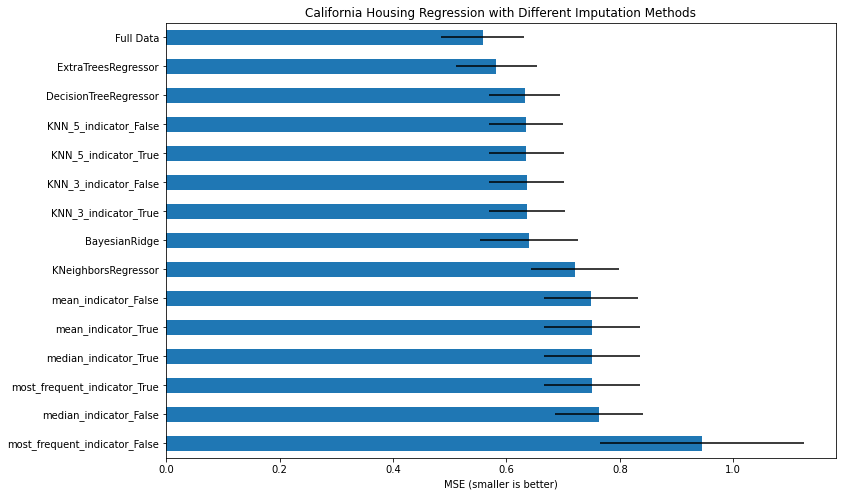

In [32]:
df.plot(
    kind='barh',  
    y="Mean", 
    xerr="Std", 
    title='California Housing Regression with Different Imputation Methods',
    legend=False, 
    figsize=(12, 8),
)
    
plt.xlabel('MSE (smaller is better)');

I tested additional ways to deal with missing values. In this one limited test, where the data is missing completely at random, the iterative imputation methods performed best. KNNImputer could be tested with Different KNN values.

Missing value indicators didn't have a large impact. Picking the most frequent value was a big loser.

Main takeaways:
1. the imputation strategy can matter ALOT for performance.
2. multiple imputation was best in this case. KNN with small N next best, but not a big deal with basic strategy used - although most frequent was a real loser in this case.

### Next steps

Make functions to do with multiple datasets.
Do analysis of performance across a variety of datasets.
Maybe just do OHE and take top 10 features for all of them.

Keeping more of the data, ExtraTreesRegressor still by far the best, but all other multiple imputers and KNNs about the same. Missing indicator dosn't matter much. KNeighborsRegressor not good. Most frequent and med and median not good.

Bayesian ridge iterative imputer did second best in the docs example when only using 1/10 of the data - not so with all the data.